# EAD per NUTS-regions

Create plots of the total EAD per NUTS-regions (at different levels of NUTS-aggregation). This is used for the COACCH Deliverable (and input for other partners); and in the article.

Uses the following post-processing output:
 - road_type_litmix
 

In [1]:
import sys
sys.path.append("..") #import folder which is one level higher

import csv
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
import os as os
import postproc_functions as post
import pandas as pd
from tqdm import tqdm

from utils_functions import load_config
from postproc_functions import *

In [2]:
# Load the background NUTS-division shapefiles as background maps.
NUTS3_raw = gpd.read_file(os.path.join(load_config()['paths']['input_data'],load_config()['filenames']['NUTS3-shape']))
NUTS3 = NUTS3_raw.copy()

In [3]:
### DEFINE THE DOMAIN TO PLOT ###
#Filter countries
N0_domain = NUTS_0_list(EU28 = True, EFTA=True, CAND=True)
N0_exclude = ['MT','CY','TR','IS']
N0_domain = [elem for elem in N0_domain if elem not in N0_exclude] #35 countries remaining

#Select corresponding Nuts-3 regions
N3_domain = []
for N0 in N0_domain:
    N3_domain.extend(NUTS_up(N0,True)) #1519 NUTS-3 regions

N3_domain = [elem for elem in N3_domain if elem not in NUTS_3_remote(Overseas=True,Creta=True,Spain=True)]
#len(N3_domain) #1419 NUTS-3 regions remain

#filter out regions with no floods (because of flood in the boundary, or no floods at all)
with open("../temp/NUTS3_nofloods_rp500.csv", 'r') as f:
  reader = csv.reader(f)
  no_floods = list(reader)[0]

with open("../temp/NUTS3_justboundaryfloods.csv", 'r') as f:
  reader = csv.reader(f)
  boundary_floods = list(reader)[0]

N3_domain = [elem for elem in N3_domain if elem not in no_floods]
N3_domain = [elem for elem in N3_domain if elem not in boundary_floods]
len(N3_domain)

NUTS3 = NUTS3[NUTS3['NUTS_ID'].isin(N3_domain)]
NUTS3.shape

#for later plotting of the background map
NUTS3_empty = NUTS3_raw[NUTS3_raw['NUTS_ID'].isin(no_floods+boundary_floods)]

In [4]:
NUTS3_empty = NUTS3_empty[NUTS3_empty.NUTS_ID!='IS001']

In [5]:
#load the relevant postprocessing output data
postproc_output = os.path.join(load_config()['paths']['postproc_output'],'baseline')

### LOAD AND STRUCTURE THE OSM LIGHTING MIX RESULTS WHICH HAVE ALREADY BEEN POSTPROCESSED
df = pd.DataFrame()
exceptions = []
for region in tqdm(N3_domain):
    try:
        df = df.append(pd.read_pickle(os.path.join(postproc_output,"{}_EAD_roadtype_litmix.pkl".format(region))))
    except Exception as e:
        exceptions.append(str(region)+str(e))

100%|█████████████████████████████████████████████████████████████████████████████| 1285/1285 [00:06<00:00, 196.08it/s]


In [6]:
exceptions #EL527, UKK41 and UKD47 are not a big deal; all 'floods-at-boundary' issues

["EL527[Errno 2] No such file or directory: 'D:\\\\Europe_trade_disruptions\\\\EuropeFloodResults\\\\Model09_beta\\\\postproc\\\\baseline\\\\EL527_EAD_roadtype_litmix.pkl'",
 "UKK41[Errno 2] No such file or directory: 'D:\\\\Europe_trade_disruptions\\\\EuropeFloodResults\\\\Model09_beta\\\\postproc\\\\baseline\\\\UKK41_EAD_roadtype_litmix.pkl'",
 "UKD47[Errno 2] No such file or directory: 'D:\\\\Europe_trade_disruptions\\\\EuropeFloodResults\\\\Model09_beta\\\\postproc\\\\baseline\\\\UKD47_EAD_roadtype_litmix.pkl'"]

In [7]:
#take the mean of the two EAD estimates and drop all other columns
df['EAD_flowavg'] = df[['EAD_lowflow','EAD_highflow']].mean(axis=1)
df = df.drop(['EAD_HZ','EAD_lowflow','EAD_highflow'],axis=1)
#create pivot table to get NUTS-3 as index and road_types as columns
df2 = df.pivot_table(index='NUTS-3',columns='road_type',values='EAD_flowavg')
df2 = df2.drop(['track','none'],axis=1) #drop un-used values
df2 = df2.reindex(['motorway','trunk','primary','secondary','tertiary','other'], axis=1)
df2.columns=(['Motorway','Trunk','Primary','Secondary','Tertiary','Other'])
df2.head()

,Motorway,Trunk,Primary,Secondary,Tertiary,Other
NUTS-3,,,,,,
AL011,NaN,NaN,NaN,7174.488352,229.445880,767.734007
AL012,NaN,NaN,7347.173333,12834.900674,8097.203146,20963.875993
AL013,2962.395169,3520.936217,21190.811985,4468.705318,5471.882322,13088.848839
AL014,NaN,NaN,2893.147228,16.231498,633.580449,775.943034
AL015,4676.867453,NaN,NaN,1588.737228,1798.560524,2393.706966


In [8]:
#sum all the columns to a total value
df3 = pd.DataFrame(df2.sum(axis=1))
df3.columns=(['Total'])
df3.tail(n=2)

,Total
NUTS-3,
UKN15,7390.938202
UKN16,146638.463764


In [9]:
df4 = NUTS3.merge(df3,left_on='FID',right_index=True,how='left')
df4.fillna(0) #replace nans with 0
df4['Total'] = df4['Total']*10**(-6)
df4.head(n=3)

,LEVL_CODE,NUTS_ID,CNTR_CODE,NUTS_NAME,FID,geometry,Total
0,3,HR043,HR,Krapinsko-zagorska županija,HR043,"POLYGON ((4804562.000 2571297.000, 4803972.000...",0.030530
1,3,AT314,AT,Steyr-Kirchdorf,AT314,"POLYGON ((4654777.000 2787028.000, 4653848.000...",0.154685
2,3,AT315,AT,Traunviertel,AT315,"POLYGON ((4600507.000 2785382.000, 4600808.000...",0.123238


In [10]:
#Table: top-20 NUTS-3 regions with the largest EAD to road infrastructure
df4.sort_values(by='Total',ascending=False).head(n=20)[['FID','NUTS_NAME','Total']]#.to_clipboard() #table for the deliverable

,FID,NUTS_NAME,Total
490,CH012,Valais,2.615573
859,FI1D7,Lappi,2.313949
816,NO060,Trøndelag,2.187132
798,FRK26,Rhône,2.077445
764,NO021,Hedmark,2.056702
933,ITI14,Firenze,1.829062
954,ITI17,Pisa,1.694312
3,DE600,Hamburg,1.685112
1128,ITI43,Roma,1.615286
786,FRI12,Gironde,1.578106


In [11]:
df41 = df4[df4['Total'].notnull()]
#df41.sort_values(by='Total')

# Plot the results on the NUTS-3 level

In [12]:
#Set axis extend (in EPSG 3035)
x_axis = (2500000,6000000)
y_axis = (1500000,5000000)
background = r"D:\Europe_trade_disruptions\NUTS-2_shapes\NUTS_2016\CNTR_RG_01M_2016_3035.shp\CNTR_RG_01M_2016_3035.shp"
background = gpd.read_file(background)

### Load the NUTS-0 shape to plot the country borders
NUTS0 = gpd.read_file(os.path.join(load_config()['paths']['input_data'],load_config()['filenames']['NUTS0-shape']))

In [13]:
#load the data for which we know that there are no floods (to distinghuish them from regions with errors)
import matplotlib as mpl
lst = ['#ffffcc','#ffeda0','#fed976','#feb24c','#fd8d3c','#fc4e2a','#e31a1c','#bd0026','#800026']
#lst = ['#fff5eb','#fee6ce','#fdd0a2','#fdae6b','#fd8d3c','#f16913','#d94801','#a63603','#7f2704']
lst = lst[1::] #ignore the first colour (too pale)
lst2 = mpl.colors.ListedColormap(lst)
lst3 = mpl.colors.LinearSegmentedColormap.from_list(name='hoi',colors=lst,N=256)

Text(0, 0.5, 'EAD in million Euro per year')

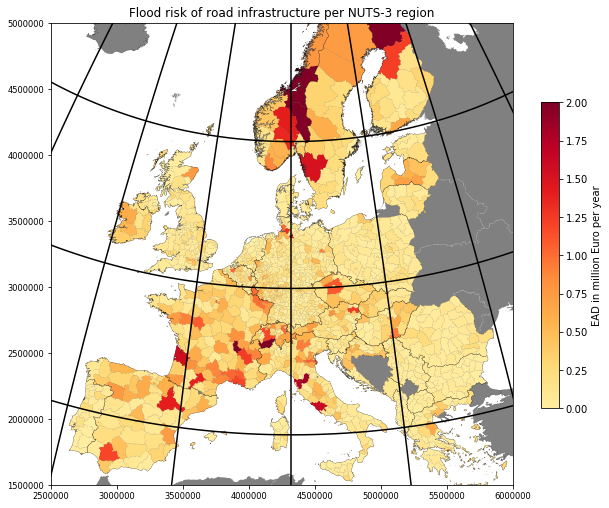

In [14]:
plt.rcParams['axes.facecolor'] = 'white'
fig, ax = plt.subplots(1, 1, figsize=(12.5, 8.5))

background.plot(color='grey',ax=ax)
NUTS3_empty.plot(color=lst[1],ax=ax) #plot all the regions for which we know that there is no damage


ax = df41.plot(column='Total', ax=ax, legend=False, cmap=lst3, vmin=0, vmax=2.0)
ax.set_title("Flood risk of road infrastructure per NUTS-3 region")

NUTS0.plot(facecolor='none',ax=ax,edgecolor='black',linewidth=0.15)

ax.set_xlim(x_axis)
ax.set_ylim(y_axis)


#New feature (14/4/2020): plot the gridlines of WGS84
Ps, Ms = post.create_gridlines([30,40,50,60,70],
                      [-30,-20,-10,0,10,20,30,40,50,60,70],
                      point_spacing = 1000)
Ps = Ps.to_crs("EPSG:3035")
Ms = Ms.to_crs("EPSG:3035")
Ps.plot(ax=ax,color='black')
Ms.plot(ax=ax,color='black')

#ax.set_xlabel(None, color="grey")
ax.tick_params(axis='both', colors='black',labelsize='small',labelcolor='black')

#Prepare the colorbar in its own axis
cb_ax = fig.add_axes([0.8, 0.25, 0.02, 0.5])
cbar = fig.colorbar(mappable=ax.collections[2],cax=cb_ax)
cbar.ax.set_ylabel('EAD in million Euro per year')
#plt.savefig(os.path.join('Paper_fig6.png'),format = 'png',bbox_inches='tight',dpi=300)
#plt.savefig(os.path.join('Paper_fig6.pdf'),format = 'pdf',bbox_inches='tight')

# NOT USED IN THE PAPER ANYMORE # Undo the GDP correction for NUTS-3

In [19]:
df410 = df41.copy()
df410

,LEVL_CODE,NUTS_ID,CNTR_CODE,NUTS_NAME,FID,geometry,Total
0,3,HR043,HR,Krapinsko-zagorska županija,HR043,"POLYGON ((4804562 2571297, 4803972 2570194, 48...",0.030530
1,3,AT314,AT,Steyr-Kirchdorf,AT314,"POLYGON ((4654777 2787028, 4653848 2786347, 46...",0.154685
2,3,AT315,AT,Traunviertel,AT315,"POLYGON ((4600507 2785382, 4600808 2784761, 46...",0.123238
3,3,DE600,DE,Hamburg,DE600,"(POLYGON ((4317388 3393935, 4317732 3393702, 4...",1.685112
5,3,DE712,DE,"Frankfurt am Main, Kreisfreie Stadt",DE712,"POLYGON ((4220259 3006223, 4220166 3007213, 42...",0.591176
...,...,...,...,...,...,...,...
1515,3,UKJ43,UK,Kent Thames Gateway,UKJ43,"(POLYGON ((3692324 3176225, 3692834 3175252, 3...",0.001409
1517,3,UKN16,UK,Fermanagh and Omagh,UKN16,"POLYGON ((3242094 3646131, 3242086 3645152, 32...",0.146638
1518,3,UKJ44,UK,East Kent,UKJ44,"POLYGON ((3679891 3130408, 3680192 3130604, 36...",0.017575
1519,3,UKJ45,UK,Mid Kent,UKJ45,"POLYGON ((3668064 3177912, 3668350 3177577, 36...",0.040571


In [20]:
df410['NUTS-0'] = df410['FID'].apply(lambda x: post.NUTS_down(post.NUTS_down(post.NUTS_down(x))))
df410

,LEVL_CODE,NUTS_ID,CNTR_CODE,NUTS_NAME,FID,geometry,Total,NUTS-0
0,3,HR043,HR,Krapinsko-zagorska županija,HR043,"POLYGON ((4804562 2571297, 4803972 2570194, 48...",0.030530,HR
1,3,AT314,AT,Steyr-Kirchdorf,AT314,"POLYGON ((4654777 2787028, 4653848 2786347, 46...",0.154685,AT
2,3,AT315,AT,Traunviertel,AT315,"POLYGON ((4600507 2785382, 4600808 2784761, 46...",0.123238,AT
3,3,DE600,DE,Hamburg,DE600,"(POLYGON ((4317388 3393935, 4317732 3393702, 4...",1.685112,DE
5,3,DE712,DE,"Frankfurt am Main, Kreisfreie Stadt",DE712,"POLYGON ((4220259 3006223, 4220166 3007213, 42...",0.591176,DE
...,...,...,...,...,...,...,...,...
1515,3,UKJ43,UK,Kent Thames Gateway,UKJ43,"(POLYGON ((3692324 3176225, 3692834 3175252, 3...",0.001409,UK
1517,3,UKN16,UK,Fermanagh and Omagh,UKN16,"POLYGON ((3242094 3646131, 3242086 3645152, 32...",0.146638,UK
1518,3,UKJ44,UK,East Kent,UKJ44,"POLYGON ((3679891 3130408, 3680192 3130604, 36...",0.017575,UK
1519,3,UKJ45,UK,Mid Kent,UKJ45,"POLYGON ((3668064 3177912, 3668350 3177577, 36...",0.040571,UK


In [21]:
from postproc_functions import GDP_corr_national
ratios = GDP_corr_national(2015)

In [82]:
df410['GDP_correction_factor'] = df410['NUTS-0'].apply(lambda x: ratios[x])
df410['Total_corrected'] = df410['Total'] / df410['GDP_correction_factor']
df410

NameError: name 'df410' is not defined

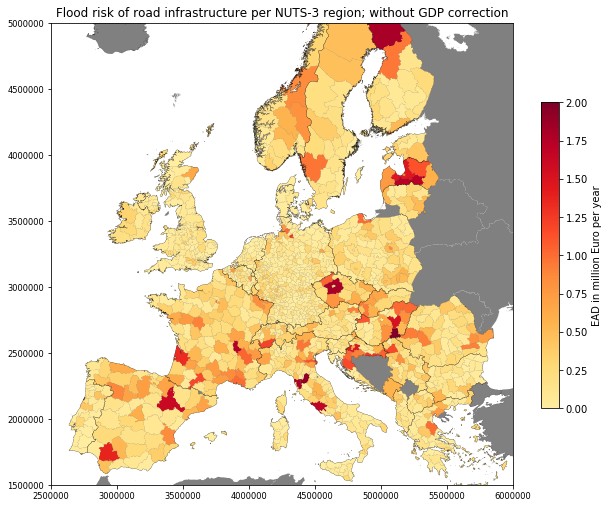

In [50]:
### Plot the NUTS-3 figure where the GDP-correction has been made undone

plt.rcParams['axes.facecolor'] = 'white'
fig, ax = plt.subplots(1, 1, figsize=(12.5, 8.5))

background.plot(color='grey',ax=ax)
NUTS3_empty.plot(color=lst[1],ax=ax) #plot all the regions for which we know that there is no damage


ax = df410.plot(column='Total_corrected', ax=ax, legend=False, cmap=lst3, vmin=0, vmax=2.0)
ax.set_title("Flood risk of road infrastructure per NUTS-3 region; without GDP correction")

NUTS0.plot(facecolor='none',ax=ax,edgecolor='black',linewidth=0.15) #plot the country contours

ax.set_xlim(x_axis)
ax.set_ylim(y_axis)

#ax.set_xlabel(None, color="grey")
ax.tick_params(axis='both', colors='black',labelsize='small',labelcolor='black')

#Prepare the colorbar in its own axis
cb_ax = fig.add_axes([0.8, 0.25, 0.02, 0.5])
cbar = fig.colorbar(mappable=ax.collections[2],cax=cb_ax)
cbar.ax.set_ylabel('EAD in million Euro per year')
#plt.savefig(os.path.join('Paper_fig6_noGDPcorr.png'),format = 'png',bbox_inches='tight',dpi=300)

### Plot them together

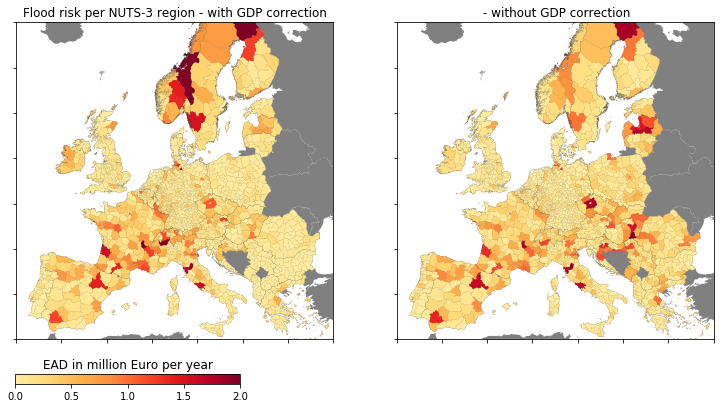

In [61]:
plt.rcParams['axes.facecolor'] = 'white'
fig, ax = plt.subplots(1, 2, figsize=(12.5, 7))

#left-hand side
background.plot(color='grey',ax=ax[0])
NUTS3_empty.plot(color=lst[1],ax=ax[0]) #plot all the regions for which we know that there is no damage


df410.plot(column='Total', ax=ax[0], legend=False, cmap=lst3, vmin=0, vmax=2.0)

NUTS0.plot(facecolor='none',ax=ax[0],edgecolor='black',linewidth=0.05) #plot the country contours

ax[0].set_title("Flood risk per NUTS-3 region - with GDP correction")
ax[0].set_xlim(x_axis)
ax[0].set_ylim(y_axis)
#ax.set_xlabel(None, color="grey")
ax[0].tick_params(axis='both', colors='black',labelsize='small',labelcolor='black', labelbottom=False, labelleft = False)

#########################################################

#right-hand side
background.plot(color='grey',ax=ax[1])
NUTS3_empty.plot(color=lst[1],ax=ax[1]) #plot all the regions for which we know that there is no damage

df410.plot(column='Total_corrected', ax=ax[1], legend=False, cmap=lst3, vmin=0, vmax=2.0)
NUTS0.plot(facecolor='none',ax=ax[1],edgecolor='black',linewidth=0.05) #plot the country contours

ax[1].set_title(" - without GDP correction")
ax[1].set_xlim(x_axis)
ax[1].set_ylim(y_axis)
#ax.set_xlabel(None, color="grey")
ax[1].tick_params(axis='both', colors='black',labelsize='small',labelcolor='black', labelbottom=False,labelleft=False) 

####

#Prepare the colorbar in its own axis
cb_ax = fig.add_axes([0.124, 0.1, 0.25, 0.02])
cbar = fig.colorbar(mappable=ax[1].collections[2],cax=cb_ax,orientation="horizontal")
#cbar.ax.set_ylabel('EAD in million Euro per year',rotation='horizontal',y=0.5)
cbar.ax.set_title('EAD in million Euro per year')

#fig.suptitle('Flood risk per NUTS-3 region', fontsize=16)

#plt.savefig(os.path.join('Paper_fig6_both_test.png'),format = 'png',bbox_inches='tight',dpi=300)

# Plot on other NUTS-levels

In [23]:
#NUTS-down the NUTS-3 level results to the other aggregation levels
df6 = df3.copy()
df6['NUTS-3'] = df6.index
df6['NUTS-2'] = df6['NUTS-3'].apply(lambda x: post.NUTS_down(x))
df6['NUTS-1'] = df6['NUTS-3'].apply(lambda x: post.NUTS_down(post.NUTS_down(x)))
df6['NUTS-0'] = df6['NUTS-3'].apply(lambda x: post.NUTS_down(post.NUTS_down(post.NUTS_down(x))))
N2 = df6.groupby('NUTS-2').sum()
N1 = df6.groupby('NUTS-1').sum()
N0 = df6.groupby('NUTS-0').sum()

## NUTS-2

In [24]:
#prepare the NUTS-2 map
NUTS2 = gpd.read_file(os.path.join(load_config()['paths']['input_data'],load_config()['filenames']['NUTS2-shape']))
df12 = NUTS2.merge(N2,left_on='FID',right_index=True,how='right')
df12['Total'] = df12['Total']*10**(-6)
df12.head(n=5)

,LEVL_CODE,NUTS_ID,CNTR_CODE,NUTS_NAME,FID,geometry,Total
0.0,2.0,CH02,CH,Espace Mittelland,CH02,"(POLYGON ((4122858 2703564, 4123475 2703272, 4...",1.971165
1.0,2.0,CH03,CH,Nordwestschweiz,CH03,"(POLYGON ((4122858 2703564, 4123043 2703555, 4...",1.173875
2.0,2.0,AL02,AL,Qender,AL02,"POLYGON ((5178239 2085654, 5180303 2086526, 51...",0.021748
3.0,2.0,AL03,AL,Jug,AL03,"(POLYGON ((5211963 2061669, 5214972 2061477, 5...",0.098505
4.0,2.0,BG33,BG,Североизточен,BG33,"(POLYGON ((5803878 2477397, 5803759 2475699, 5...",0.028691


In [26]:
#Table: top-10 NUTS-3 regions with the largest EAD to road infrastructure
df12.sort_values(by='Total',ascending=False).head(n=20)[['FID','NUTS_NAME','Total']] #.to_clipboard()

,FID,NUTS_NAME,Total
252.0,FRK2,Rhône-Alpes,6.607007
151.0,ITI1,Toscana,4.725925
125.0,FI1D,Pohjois- ja Itä-Suomi,4.353043
216.0,FRI1,Aquitaine,4.140299
220.0,FRJ2,Midi-Pyrénées,4.132523
105.0,FR10,Ile-de-France,3.785114
145.0,NO02,Hedmark og Oppland,3.473658
135.0,HR04,Kontinentalna Hrvatska,3.383222
236.0,FRL0,Provence-Alpes-Côte d’Azur,3.327437
59.0,ITH3,Veneto,3.295133


In [22]:
df12.sort_values(by='Total',ascending=True).head(n=10)[['FID','NUTS_NAME','Total']]

,FID,NUTS_NAME,Total
60.0,EL41,Βόρειο Αιγαίο,0.000045
294.0,UKD7,Merseyside,0.000389
283.0,UKK3,Cornwall and Isles of Scilly,0.001488
305.0,UKI6,Outer London - South,0.004026
155.0,NL13,Drenthe,0.004252
10.0,ES53,Illes Balears,0.005353
166.0,NL34,Zeeland,0.009954
162.0,NL23,Flevoland,0.010443
154.0,NL12,Friesland (NL),0.010457
78.0,EL30,Aττική,0.012156


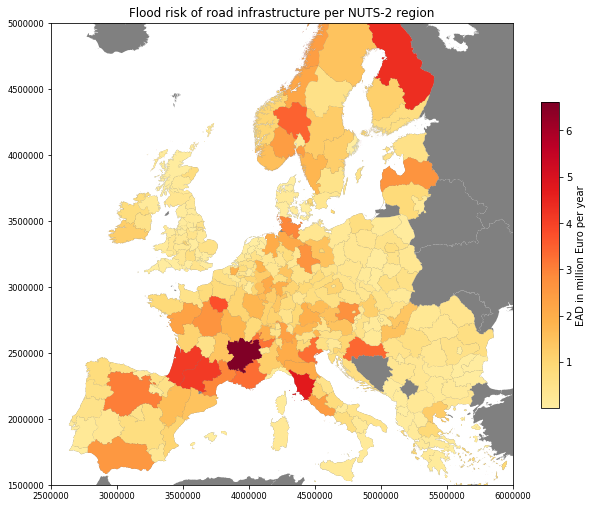

In [51]:
#plot the NUTS-2 map
fig, ax = plt.subplots(1, 1, figsize=(12.5, 8.5))

background.plot(color='grey',ax=ax)
NUTS3_empty.plot(color=lst[1],ax=ax) #plot all the regions for which we know that there is no damage

ax = df12.plot(column='Total', ax=ax, legend=False, cmap=lst3) #afmhot_r
ax.set_title("Flood risk of road infrastructure per NUTS-2 region")

ax.tick_params(axis='both', colors='black',labelsize='small',labelcolor='black')

ax.set_xlim(x_axis)
ax.set_ylim(y_axis)

cb_ax = fig.add_axes([0.8, 0.25, 0.02, 0.5])
cbar = fig.colorbar(mappable=ax.collections[2],cax=cb_ax)
cbar.ax.set_ylabel('EAD in million Euro per year')
plt.savefig(os.path.join('Paper_fig_SI4_NUTS2.png'),format = 'png',bbox_inches='tight',dpi=400)

In [88]:
df12.to_clipboard()

In [24]:
df12.sort_values(by='Total',axis=0).head(n=20)

,LEVL_CODE,NUTS_ID,CNTR_CODE,NUTS_NAME,FID,geometry,Total
60.0,2.0,EL41,EL,Βόρειο Αιγαίο,EL41,"(POLYGON ((5727040 1961599, 5726417 1959374, 5...",0.000045
294.0,2.0,UKD7,UK,Merseyside,UKD7,"(POLYGON ((3470407 3475254, 3470780 3474186, 3...",0.000389
283.0,2.0,UKK3,UK,Cornwall and Isles of Scilly,UKK3,"(POLYGON ((3318908 3138087, 3317726 3137651, 3...",0.001488
305.0,2.0,UKI6,UK,Outer London - South,UKI6,"POLYGON ((3637961 3190363, 3638352 3189728, 36...",0.004026
155.0,2.0,NL13,NL,Drenthe,NL13,"POLYGON ((4107505 3333865, 4110506 3330399, 41...",0.004252
10.0,2.0,ES53,ES,Illes Balears,ES53,"(POLYGON ((3735722 1899591, 3735929 1899445, 3...",0.005353
166.0,2.0,NL34,NL,Zeeland,NL34,"(POLYGON ((3922965 3186450, 3922500 3185060, 3...",0.009954
162.0,2.0,NL23,NL,Flevoland,NL23,"POLYGON ((4037609 3307942, 4038152 3306781, 40...",0.010443
154.0,2.0,NL12,NL,Friesland (NL),NL12,"(POLYGON ((4067838 3373652, 4066167 3371491, 4...",0.010457
78.0,2.0,EL30,EL,Aττική,EL30,"(POLYGON ((5518880 1803024, 5520904 1802889, 5...",0.012156


## NUTS-1

In [26]:
#prepare the NUTS-1 map
NUTS1 = gpd.read_file(os.path.join(load_config()['paths']['input_data'],load_config()['filenames']['NUTS1-shape']))
df11 = NUTS1.merge(N1,left_on='FID',right_index=True,how='right')
df11['Total'] = df11['Total']*10**(-6)
df11.tail(n=5)

,LEVL_CODE,NUTS_ID,CNTR_CODE,NUTS_NAME,FID,geometry,Total
108,1,UKM,UK,SCOTLAND,UKM,"(POLYGON ((3461377 3908521, 3460801 3907648, 3...",1.540605
109,1,MK0,MK,ПОРАНЕШНА ЈУГОСЛОВЕНСКА РЕПУБЛИКА МАКЕДОНИЈА,MK0,"POLYGON ((5338320 2217739, 5338919 2217555, 53...",0.235718
110,1,NL1,NL,NOORD-NEDERLAND,NL1,"(POLYGON ((4113226 3371155, 4114011 3369645, 4...",0.041240
111,1,NL2,NL,OOST-NEDERLAND,NL2,"POLYGON ((4059751 3312033, 4061769 3308930, 40...",0.651658
112,1,NL3,NL,WEST-NEDERLAND,NL3,"(POLYGON ((4009190 3305020, 4007469 3295195, 4...",0.471908


In [27]:
df11.sort_values(by='Total',axis=0).tail(n=10)

,LEVL_CODE,NUTS_ID,CNTR_CODE,NUTS_NAME,FID,geometry,Total
28,1,DE9,DE,NIEDERSACHSEN,DE9,"(POLYGON ((4256375 3414615, 4256104 3415203, 4...",5.263286
56,1,FRI,FR,AQUITAINE-LIMOUSIN-POITOU-CHARENTES,FRI,"(POLYGON ((3568838 2722831, 3569479 2720505, 3...",5.783283
33,1,FI1,FI,MANNER-SUOMI,FI1,"(POLYGON ((5073773 5207018, 5070834 5202927, 5...",6.905047
66,1,FRJ,FR,LANGUEDOC-ROUSSILLON-MIDI-PYRÉNÉES,FRJ,"(POLYGON ((3695181 2462729, 3695454 2462301, 3...",7.058512
55,1,ITH,IT,NORD-EST,ITH,"(POLYGON ((4491314 2664310, 4491005 2663892, 4...",7.498850
21,1,DE2,DE,BAYERN,DE2,"(POLYGON ((4355225 2715903, 4354123 2712437, 4...",7.704339
61,1,FRK,FR,AUVERGNE-RHÔNE-ALPES,FRK,"POLYGON ((3789420 2656258, 3789428 2656086, 37...",8.040700
65,1,ITI,IT,CENTRO (IT),ITI,"(POLYGON ((4332349 2360377, 4333891 2359244, 4...",8.736315
1,1,CH0,CH,SCHWEIZ/SUISSE/SVIZZERA,CH0,"POLYGON ((4217105 2744026, 4217669 2743197, 42...",10.243117
36,1,NO0,NO,NORGE,NO0,"(POLYGON ((5073773 5207018, 5070082 5208825, 5...",13.310881


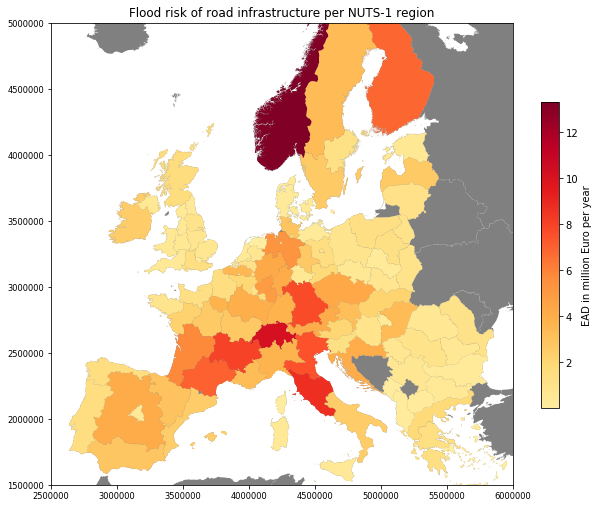

In [52]:
#plot the NUTS-1 map
fig, ax = plt.subplots(1, 1, figsize=(12.5, 8.5))

background.plot(color='grey',ax=ax)
NUTS3_empty.plot(color=lst[1],ax=ax) #plot all the regions for which we know that there is no damage

ax = df11.plot(column='Total', ax=ax, legend=False, cmap=lst3) #afmhot_r
ax.set_title("Flood risk of road infrastructure per NUTS-1 region")

ax.tick_params(axis='both', colors='black',labelsize='small',labelcolor='black')

ax.set_xlim(x_axis)
ax.set_ylim(y_axis)

cb_ax = fig.add_axes([0.8, 0.25, 0.02, 0.5])
cbar = fig.colorbar(mappable=ax.collections[2],cax=cb_ax)
cbar.ax.set_ylabel('EAD in million Euro per year')
plt.savefig(os.path.join('Paper_fig_SI4_NUTS1.png'),format = 'png',bbox_inches='tight',dpi=400)

## NUTS-0 (country)

In [29]:
#prepare the NUTS-0 map
NUTS0 = gpd.read_file(os.path.join(load_config()['paths']['input_data'],load_config()['filenames']['NUTS0-shape']))
df10 = NUTS0.merge(N0,left_on='FID',right_index=True,how='right')
df10['Total'] = df10['Total']*10**(-6)
df10.tail(n=5)

,LEVL_CODE,NUTS_ID,CNTR_CODE,NUTS_NAME,FID,EU-28,geometry,Total
32,0,UK,UK,UNITED KINGDOM,UK,1,"(POLYGON ((3461377 3908521, 3460801 3907648, 3...",8.476356
33,0,RS,RS,REPUBLIKA SRBIJA /РЕПУБЛИКА СРБИЈА,RS,0,"(POLYGON ((5068154 2612699, 5069619 2611684, 5...",1.293436
34,0,SE,SE,SVERIGE,SE,1,"(POLYGON ((4967896 4811191, 4966825 4810683, 4...",7.193122
35,0,PT,PT,PORTUGAL,PT,1,"(POLYGON ((2822605 2261163, 2823590 2260827, 2...",1.503361
36,0,RO,RO,ROMÂNIA,RO,1,"(POLYGON ((5616142 2872864, 5616994 2872494, 5...",3.254633


In [30]:
df10.sort_values(by='Total',axis=0).tail(n=10)

,LEVL_CODE,NUTS_ID,CNTR_CODE,NUTS_NAME,FID,EU-28,geometry,Total
12,0,FI,FI,SUOMI / FINLAND,FI,1,"(POLYGON ((5073773 5207018, 5070834 5202927, 5...",6.905047
34,0,SE,SE,SVERIGE,SE,1,"(POLYGON ((4967896 4811191, 4966825 4810683, 4...",7.193122
32,0,UK,UK,UNITED KINGDOM,UK,1,"(POLYGON ((3461377 3908521, 3460801 3907648, 3...",8.476356
5,0,AT,AT,ÖSTERREICH,AT,1,"(POLYGON ((4355225 2715903, 4356642 2715308, 4...",9.373402
8,0,CH,CH,SCHWEIZ/SUISSE/SVIZZERA,CH,0,"POLYGON ((4217105 2744026, 4217669 2743197, 42...",10.243117
22,0,NO,NO,NORGE,NO,0,"(POLYGON ((5073773 5207018, 5070082 5208825, 5...",13.310881
11,0,ES,ES,ESPAÑA,ES,1,"(POLYGON ((2906665 2459936, 2907941 2459139, 2...",14.457275
18,0,IT,IT,ITALIA,IT,1,"(POLYGON ((4491314 2664310, 4491005 2663892, 4...",22.891689
13,0,FR,FR,FRANCE,FR,1,"(POLYGON ((3802065 3115283, 3802023 3115130, 3...",43.357868
2,0,DE,DE,DEUTSCHLAND,DE,1,"(POLYGON ((4355225 2715903, 4354123 2712437, 4...",44.971742


In [35]:
(3*8.5 + 6*7.5 + 6 * 9 + 3 * 8.5 + 6 * 8.5)/(3+6+6+3+6)

8.375

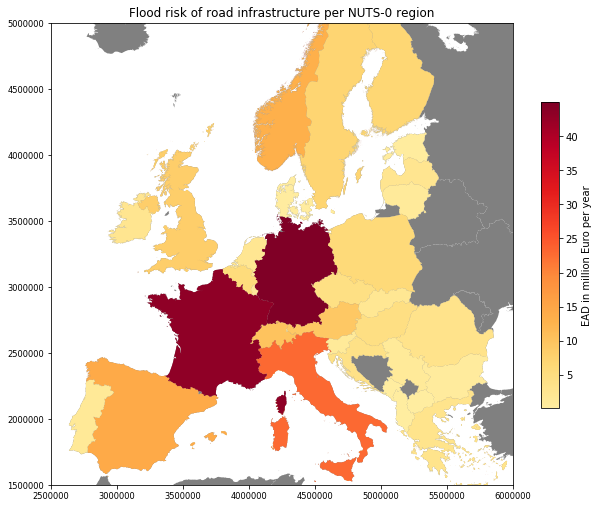

In [53]:
#plot the NUTS-1 map
fig, ax = plt.subplots(1, 1, figsize=(12.5, 8.5))

background.plot(color='grey',ax=ax)
NUTS3_empty.plot(color=lst[1],ax=ax) #plot all the regions for which we know that there is no damage

ax = df10.plot(column='Total', ax=ax, legend=False, cmap=lst3) #afmhot_r
ax.set_title("Flood risk of road infrastructure per NUTS-0 region")

ax.tick_params(axis='both', colors='black',labelsize='small',labelcolor='black')

ax.set_xlim(x_axis)
ax.set_ylim(y_axis)

cb_ax = fig.add_axes([0.8, 0.25, 0.02, 0.5])
cbar = fig.colorbar(mappable=ax.collections[2],cax=cb_ax)
cbar.ax.set_ylabel('EAD in million Euro per year')
plt.savefig(os.path.join('Paper_fig_SI4_NUTS0.png'),format = 'png',bbox_inches='tight',dpi=400)






# Start new figure in the paper 

In [24]:
# Import the GDP data by NUTS-3 region
file_path = os.path.join(load_config()['paths']['input_data'],"Eurostat_GDP_NUTS3_corr.xls")
NUTS3_GDP2015 = pd.read_excel(file_path,skiprows=8,index_col=0)['2015'] #NUTS-3 GDP in million euro per year

In [25]:
df50 = df41.copy()
df51 = pd.merge(df50,NUTS3_GDP2015,how='left',left_on='FID',right_index=True)

In [26]:
df51

,LEVL_CODE,NUTS_ID,CNTR_CODE,NUTS_NAME,FID,geometry,Total,2015
0,3,HR043,HR,Krapinsko-zagorska županija,HR043,"POLYGON ((4804562.000 2571297.000, 4803972.000...",0.030530,890.64
1,3,AT314,AT,Steyr-Kirchdorf,AT314,"POLYGON ((4654777.000 2787028.000, 4653848.000...",0.154685,6524.64
2,3,AT315,AT,Traunviertel,AT315,"POLYGON ((4600507.000 2785382.000, 4600808.000...",0.123238,8359.03
3,3,DE600,DE,Hamburg,DE600,"MULTIPOLYGON (((4317388.000 3393935.000, 43177...",1.685112,110434.62
5,3,DE712,DE,"Frankfurt am Main, Kreisfreie Stadt",DE712,"POLYGON ((4220259.000 3006223.000, 4220166.000...",0.591176,66262.69
...,...,...,...,...,...,...,...,...
1515,3,UKJ43,UK,Kent Thames Gateway,UKJ43,"MULTIPOLYGON (((3692324.000 3176225.000, 36928...",0.001409,11463.18
1517,3,UKN16,UK,Fermanagh and Omagh,UKN16,"POLYGON ((3242094.000 3646131.000, 3242086.000...",0.146638,2191.99
1518,3,UKJ44,UK,East Kent,UKJ44,"POLYGON ((3679891.000 3130408.000, 3680192.000...",0.017575,14593.71
1519,3,UKJ45,UK,Mid Kent,UKJ45,"POLYGON ((3668064.000 3177912.000, 3668350.000...",0.040571,10072.35


In [27]:
#df51['Total'] = df51['Total'].astype(float)
#df51['2015'] = df51['2015'].astype(float)
df51['Share_of_2015_GDP'] = df51['Total'] / df51['2015']

In [28]:
df51.head(n=5)

,LEVL_CODE,NUTS_ID,CNTR_CODE,NUTS_NAME,FID,geometry,Total,2015,Share_of_2015_GDP
0,3,HR043,HR,Krapinsko-zagorska županija,HR043,"POLYGON ((4804562.000 2571297.000, 4803972.000...",0.030530,890.64,0.000034
1,3,AT314,AT,Steyr-Kirchdorf,AT314,"POLYGON ((4654777.000 2787028.000, 4653848.000...",0.154685,6524.64,0.000024
2,3,AT315,AT,Traunviertel,AT315,"POLYGON ((4600507.000 2785382.000, 4600808.000...",0.123238,8359.03,0.000015
3,3,DE600,DE,Hamburg,DE600,"MULTIPOLYGON (((4317388.000 3393935.000, 43177...",1.685112,110434.62,0.000015
5,3,DE712,DE,"Frankfurt am Main, Kreisfreie Stadt",DE712,"POLYGON ((4220259.000 3006223.000, 4220166.000...",0.591176,66262.69,0.000009


In [31]:
df51.loc[df51['FID'].isin(['FI1D7','FRK26','ITI14','ITI17'])]

,LEVL_CODE,NUTS_ID,CNTR_CODE,NUTS_NAME,FID,geometry,Total,2015,Share_of_2015_GDP
798,3,FRK26,FR,Rhône,FRK26,"POLYGON ((3917849.000 2576779.000, 3917973.000...",2.077445,79832.28,0.000026
859,3,FI1D7,FI,Lappi,FI1D7,"MULTIPOLYGON (((5073773.000 5207018.000, 50708...",2.313949,6348.08,0.000365
933,3,ITI14,IT,Firenze,ITI14,"POLYGON ((4443245.000 2339855.000, 4444804.000...",1.829062,36077.55,0.000051
954,3,ITI17,IT,Pisa,ITI17,"POLYGON ((4378378.000 2297721.000, 4378606.000...",1.694312,12411.01,0.000137


In [32]:
df51.loc[df51['FID'].isin(['HR032','HR04A','HR04D','HR04C'])]

,LEVL_CODE,NUTS_ID,CNTR_CODE,NUTS_NAME,FID,geometry,Total,2015,Share_of_2015_GDP
190,3,HR04A,HR,Brodsko-posavska županija,HR04A,"POLYGON ((4954126.000 2495814.000, 4954278.000...",0.502732,896.24,0.000561
709,3,HR04D,HR,Karlovačka županija,HR04D,"POLYGON ((4784173.000 2503546.000, 4783835.000...",0.410626,979.25,0.000419
732,3,HR04C,HR,Vukovarsko-srijemska županija,HR04C,"POLYGON ((5024761.000 2522836.000, 5025726.000...",0.420617,1040.30,0.000404
805,3,HR032,HR,Ličko-senjska županija,HR032,"MULTIPOLYGON (((4774121.000 2442304.000, 47744...",0.464891,388.32,0.001197


Text(0, 0.5, 'Percentage')

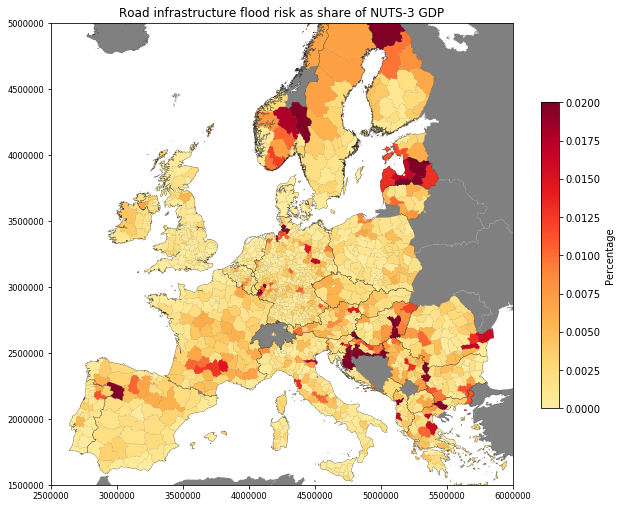

In [20]:
df52 = df51.copy()
df52['Percentage'] = 100*df52['Share_of_2015_GDP']

### Plot the NUTS-3 figure where the GDP-correction has been made undone

plt.rcParams['axes.facecolor'] = 'white'
fig, ax = plt.subplots(1, 1, figsize=(12.5, 8.5))

background.plot(color='grey',ax=ax)
NUTS3_empty.plot(color=lst[1],ax=ax) #plot all the regions for which we know that there is no damage


ax = df52.plot(column='Percentage', ax=ax, legend=False, cmap=lst3,vmax=0.02)
ax.set_title("Road infrastructure flood risk as share of NUTS-3 GDP")

NUTS0.plot(facecolor='none',ax=ax,edgecolor='black',linewidth=0.15) #plot the country contours

ax.set_xlim(x_axis)
ax.set_ylim(y_axis)

#ax.set_xlabel(None, color="grey")
ax.tick_params(axis='both', colors='black',labelsize='small',labelcolor='black')

#Prepare the colorbar in its own axis
cb_ax = fig.add_axes([0.8, 0.25, 0.02, 0.5])
cbar = fig.colorbar(mappable=ax.collections[2],cax=cb_ax)
cbar.ax.set_ylabel('Percentage')
#plt.savefig(os.path.join('Paper_fig6_noGDPcorr.png'),format = 'png',bbox_inches='tight',dpi=300)

## Plot them together

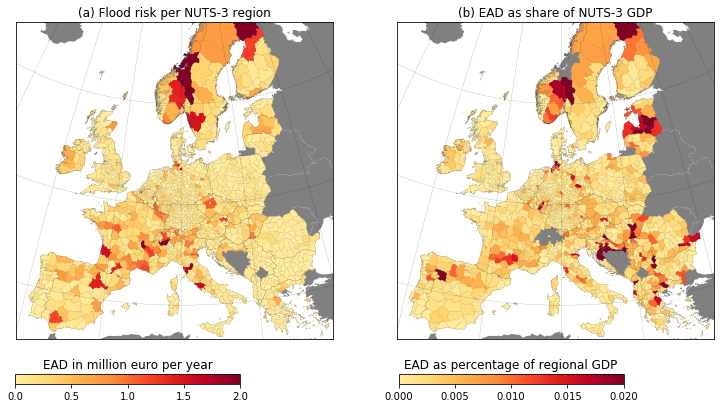

In [21]:
plt.rcParams['axes.facecolor'] = 'white'
fig, ax = plt.subplots(1, 2, figsize=(12.5, 7))

#left-hand side
background.plot(color='grey',ax=ax[0])
NUTS3_empty.plot(color=lst[1],ax=ax[0]) #plot all the regions for which we know that there is no damage


df52.plot(column='Total', ax=ax[0], legend=False, cmap=lst3, vmin=0, vmax=2.0)

NUTS0.plot(facecolor='none',ax=ax[0],edgecolor='black',linewidth=0.05) #plot the country contours

ax[0].set_title("(a) Flood risk per NUTS-3 region")
ax[0].set_xlim(x_axis)
ax[0].set_ylim(y_axis)
#ax.set_xlabel(None, color="grey")
#ax[0].tick_params(axis='both', colors='black',labelsize='small',labelcolor='black', labelbottom=False, labelleft = False)
ax[0].tick_params(axis='both',which='both',bottom=False,top=False,left=False,right=False,labelbottom=False,labelleft=False)

#########################################################

#right-hand side
background.plot(color='grey',ax=ax[1])
NUTS3_empty.plot(color=lst[1],ax=ax[1]) #plot all the regions for which we know that there is no damage

df52.plot(column='Percentage', ax=ax[1], legend=False, cmap=lst3, vmin=0, vmax=0.02)
NUTS0.plot(facecolor='none',ax=ax[1],edgecolor='black',linewidth=0.05) #plot the country contours

ax[1].set_title("(b) EAD as share of NUTS-3 GDP")
ax[1].set_xlim(x_axis)
ax[1].set_ylim(y_axis)
#ax.set_xlabel(None, color="grey")
#ax[1].tick_params(axis='both', colors='black',labelsize='small',labelcolor='black', labelbottom=False,labelleft=False) 
ax[1].tick_params(axis='both',which='both',bottom=False,top=False,left=False,right=False,labelbottom=False,labelleft=False)

####

#Prepare the left-hand colorbar in its own axis
cb_ax = fig.add_axes([0.124, 0.1, 0.25, 0.02])
cbar = fig.colorbar(mappable=ax[0].collections[2],cax=cb_ax,orientation="horizontal")
#cbar.ax.set_ylabel('EAD in million Euro per year',rotation='horizontal',y=0.5)
cbar.ax.set_title('EAD in million euro per year')

#Prepare the left-hand colorbar in its own axis
cb_ax2 = fig.add_axes([0.55, 0.1, 0.25, 0.02])
cbar2 = fig.colorbar(mappable=ax[1].collections[2],cax=cb_ax2,orientation="horizontal")
#cbar.ax.set_ylabel('EAD in million Euro per year',rotation='horizontal',y=0.5)
cbar2.ax.set_title('EAD as percentage of regional GDP')

#### #add gridlines

#New feature (14/4/2020): plot the gridlines of WGS84
Ps, Ms = post.create_gridlines([30,40,50,60,70],
                      [-30,-20,-10,0,10,20,30,40,50,60,70],
                      point_spacing = 10000)
Ps = Ps.to_crs("EPSG:3035")
Ms = Ms.to_crs("EPSG:3035")
lijndikte = 0.2
alfa = 0.5
Ps.plot(ax=ax[0],color='black',linewidth=lijndikte,alpha=alfa)
Ms.plot(ax=ax[0],color='black',linewidth=lijndikte,alpha=alfa)
Ps.plot(ax=ax[1],color='black',linewidth=lijndikte,alpha=alfa)
Ms.plot(ax=ax[1],color='black',linewidth=lijndikte,alpha=alfa)


In [24]:
fig.savefig(os.path.join('Paper_fig5_degrees.png'),format = 'png',bbox_inches='tight',dpi=300)
#plt.savefig(os.path.join('Paper_fig5.pdf'),format = 'pdf',bbox_inches='tight',dpi=300)

## Stats for SI

In [121]:
top = df52.sort_values(by='Percentage',ascending=False).head(n=20)
top

,LEVL_CODE,NUTS_ID,CNTR_CODE,NUTS_NAME,FID,geometry,Total,2015,Percentage_of_2015_GDP,Share_of_2015_GDP,Percentage
805,3,HR032,HR,Ličko-senjska županija,HR032,"MULTIPOLYGON (((4774121.000 2442304.000, 47744...",0.464891,388.32,0.119719,0.001197,0.119719
190,3,HR04A,HR,Brodsko-posavska županija,HR04A,"POLYGON ((4954126.000 2495814.000, 4954278.000...",0.502732,896.24,0.056093,0.000561,0.056093
709,3,HR04D,HR,Karlovačka županija,HR04D,"POLYGON ((4784173.000 2503546.000, 4783835.000...",0.410626,979.25,0.041933,0.000419,0.041933
732,3,HR04C,HR,Vukovarsko-srijemska županija,HR04C,"POLYGON ((5024761.000 2522836.000, 5025726.000...",0.420617,1040.30,0.040432,0.000404,0.040432
944,3,LV009,LV,Zemgale,LV009,"MULTIPOLYGON (((5260304.000 3847985.000, 52609...",0.690101,1883.65,0.036636,0.000366,0.036636
859,3,FI1D7,FI,Lappi,FI1D7,"MULTIPOLYGON (((5073773.000 5207018.000, 50708...",2.313949,6348.08,0.036451,0.000365,0.036451
686,3,DEF0E,DE,Steinburg,DEF0E,"MULTIPOLYGON (((4312104.000 3433904.000, 43110...",1.313406,4056.15,0.032381,0.000324,0.032381
10,3,BG311,BG,Видин,BG311,"POLYGON ((5330612.000 2430822.000, 5332044.000...",0.094177,295.32,0.031890,0.000319,0.031890
819,3,NO073,NO,Finnmark,NO073,"MULTIPOLYGON (((5073773.000 5207018.000, 50700...",1.096516,3695.34,0.029673,0.000297,0.029673
710,3,HR04E,HR,Sisačko-moslavačka županija,HR04E,"POLYGON ((4862728.000 2510680.000, 4863483.000...",0.363364,1238.13,0.029348,0.000293,0.029348


In [124]:
top[['NUTS_ID','NUTS_NAME','Total','2015','Percentage']].to_clipboard()